# MachineLearning : Classification

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Loading the mnist dataset

In [3]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

C:\Users\arnol\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
# 70k rows - reps the number of images,
# 784 - reps the number of features per image each feature reps. one pixels intensity from 0 (white) to 255 (black)

X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

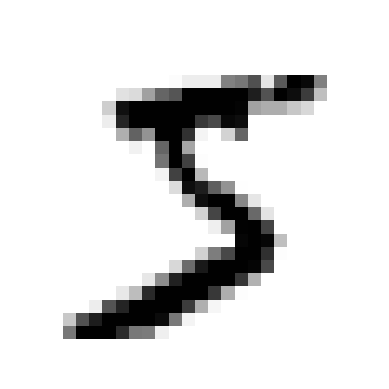

In [6]:
# To view the images we grab an instance's feature vector, reshape it to 28x28 array, and display it usin matplotlib's imshow() function.

some_digit = X.iloc[0].values
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
# checking the label
y[0]

'5'

In [8]:
# The mnist set is already split between training and test set: -
# firts 60k - training, last 10k test.

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
# The data is already shuffled thus guaranteeing all cross valdation folds will be similar (we dont want one fold missing some digits)
# Some algorithms are sensitive to the order of the training instances and perform poorly if they get similar instances in a row.

## Training a Binary Classifier

In [10]:
# Creating the target vectors for this classification task.
y_train = y_train.astype(int)
y_test = y_test.astype(int)

y_train_5 = (y_train == 5)  # true for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

### Training a Stochastic Gradient Descent Classifier (SDG)

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

C:\Users\arnol\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

# Performance Measures

## Measuring Accuracy Using Cross Validation

In [13]:
# Implementing the cross validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.values[train_index]
    y_train_folds = y_train_5.values[train_index]
    X_test_fold = X_train.values[test_index]
    y_test_fold = y_train_5.values[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [14]:
# Using the cross_val_score() function to evaluate our model.

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

#### Counter-checking the performance aganst a baseline classifier

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [17]:
#Alas! The model has over 90% accuracy, this is because only 10% of the data are 5s therefor even if we predict all as false we still get 90% accuracy.
#This is to show tha scores are not the preffered method when testing for classification model performance.

## Evaluation using Confusion Matrix

In [18]:
# We'll need a set of predictions so they can be tested against the actual targets.

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
#cross_val_predict performs the normal cross validation but instead of returning the scores, it returns the predictions made on each test fold.
# This means we get a clean prediction for each instance in the training set ("clean" because the prediction is made by a model that never saw the
#data during training)

In [20]:
# gettting the confusion matrix.

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [21]:
# First row considered none 5, 53,892 were true negatives while 687 were false positives (not 5s but classified as 5s)
# Second row considered the 5(positive class), 1,891 wrongly classified as non-5s, 3530 correctly classified as true positives.

In [22]:
# Lets pretend we reached perfection by artificially creating only true positive and true negative results.

y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Precision and Recall

In [23]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [24]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [25]:
# Precision focuses on how many positives the model got,
# Recall focuses on how many it got right out of the total that were labelled.

#### The F1 Score

In [26]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [27]:
# Getting the decision scores that scikit-learn uses to make the predictions allowing us to use any threshold to make predictions.

y_scores = sgd_clf.decision_function([some_digit])
y_scores

C:\Users\arnol\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [29]:
# Lets raise the threshold.

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

### Deciding on the threshold to use

In [30]:
# deciding on the threshold to use.

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [31]:
# getting the recall-precision function to compute the precision.

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


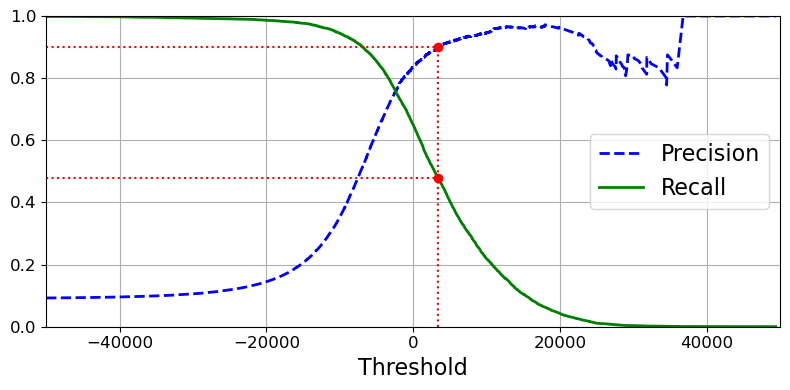

In [32]:
# We then use matplotlib to plot precision and recall as function of the threshold value:

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [33]:
# Getting the lowest threshold that gives us atleast 90% precision.

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [34]:
# To make predictions (on the training set for now), instead of calling the classifier's predict() method, we can:

y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [35]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [36]:
(y_train_pred == (y_scores > 0)).all()

True

Saving figure precision_vs_recall_plot


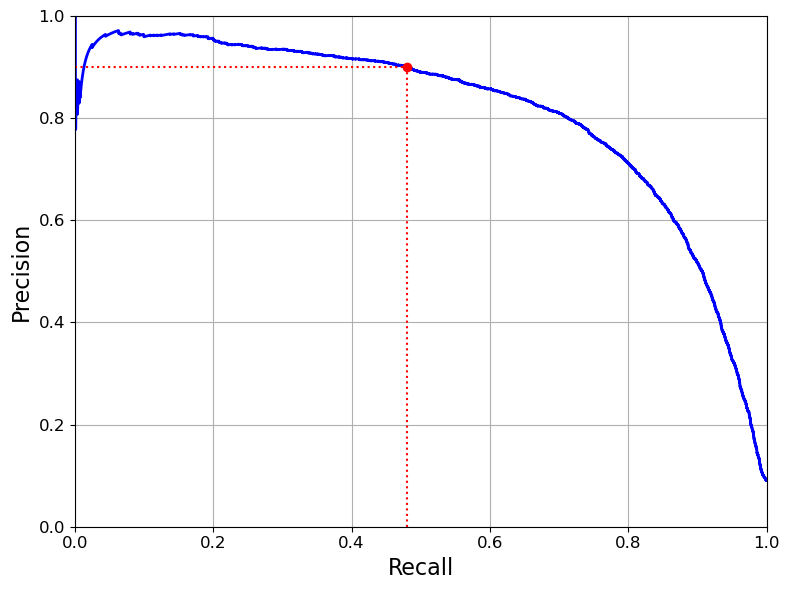

In [37]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

### The ROC Curve

In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


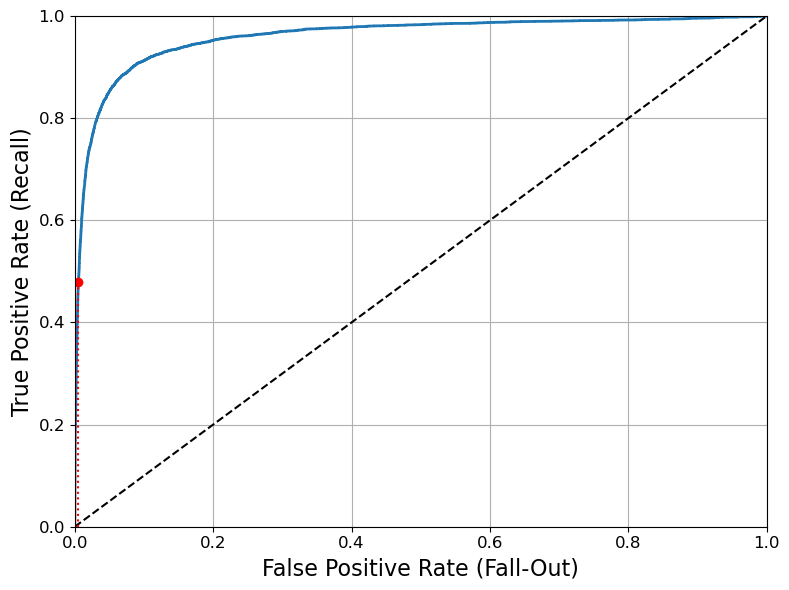

In [39]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [40]:
# The red circle highlights the chosen ratio (43.68% recall)

# We can compare classifiers by measuring the area under the curve, a perfect classify will have a ROC AUC of 1, a random one will have 0.5:


In [41]:
# We can compute the ROC AUC as follows:

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## Training a Random Forest Classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [43]:
# roc_curve function expects labels and scores, but instead of scores we can give it class probabilities, lets use the positive class probability ascore

y_scores_forest = y_probas_forest[:, 1]  # score = proba of positive class.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

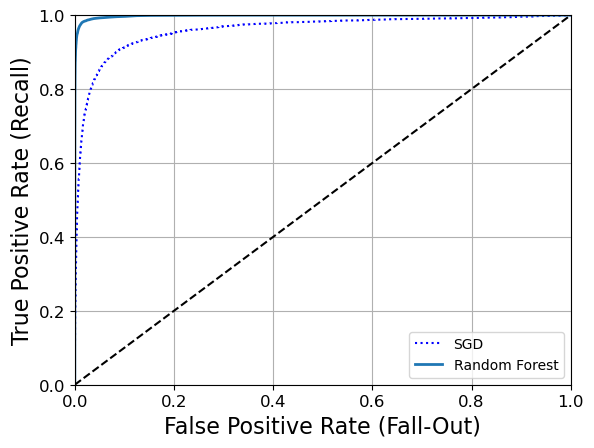

In [44]:
# Plotting the ROC curve:

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [45]:
# This curve looks so much better than the other one as it comes much closer to the top left of the graph.

roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [46]:
# Getting the precision score:

y_pred_forest = (y_scores_forest > 0.5)
precision_score(y_train_5, y_pred_forest)

0.9905083315756169

In [47]:
recall_score(y_train_5, y_pred_forest)

0.8662608374838591

## MultiClass Classification

In [49]:
# Using a binary classification classifier for a multi-class classification task.

from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

C:\Users\arnol\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5])

In [50]:
# Under the hood scikit-learn actually used the 0v0 strategy training 45 classifiers, got their decision score for the image and selected the class,
# ... that won most duels.
# If we call the decision_function() method it will return 10 scores.

some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

C:\Users\arnol\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [51]:
np.argmax(some_digit_scores)

5

In [52]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [53]:
svm_clf.classes_[5]

5

### Forcing the OvR strategy on a classifier

In [54]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

C:\Users\arnol\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\arnol\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\arnol\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\arnol\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\arnol\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\arnol\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  w

array([5])

In [55]:
# Training a SDGClassifier (or RandomForestClassifier) is just as easy:

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

C:\Users\arnol\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3])

In [56]:
# SDG classifiers can directly classify instances into multiple classes so scikit-learn doesn't have to run OvR or OvO.
# Let's look at the scores assigned to each classifier.

sgd_clf.decision_function([some_digit])

C:\Users\arnol\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [57]:
# Evaluating the SGD classifier using cross validation:

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [59]:
# We can improve the scores by simply scaling the inputs.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [60]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

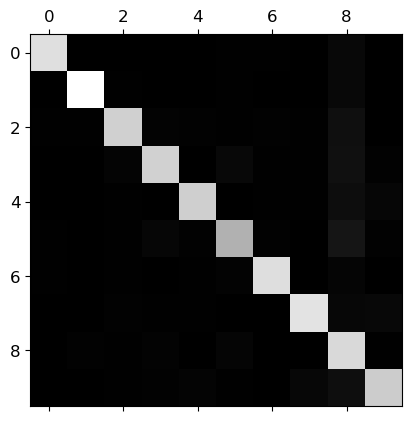

In [61]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

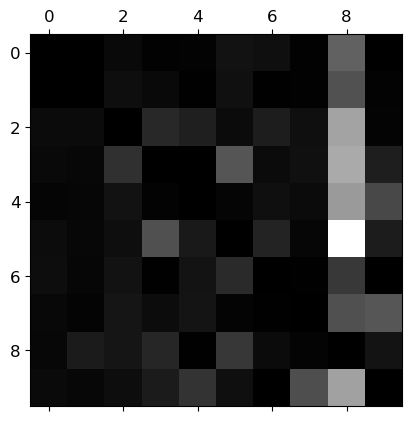

In [63]:
# Focusing on the errors we need to divide each number in the confusion matrix by the number of images in the corresponding class so we can compare,
# ... error rates instead of absolute numbers of errors ( which could make the abundant classes look unfairly bad.)

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx  /row_sums

#Keep the diagonals with zeros to keep only the errors and plot the result.
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Multilabel Classification.

In [65]:
# The KNeighborsClassifier instance supports multilabel classification though not all classifiers do.

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

C:\Users\arnol\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [67]:
# We can evaluate this classifier by calculating it's F1 score.

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## Multioutput Classification

In [68]:
# In this we can have more than two possible values.
# We'll build a system that removes noise from images. It will take as input noisy digit image and will hopefully output a clean digit image rep.
# ... as an array of pixel intensities, just like the MNIST images - the classifiers output is multilabel (one label per pixel) and each label, 
#... can have multiple values( 0 - 255) thus its an example of multioutput classification system.

In [69]:
# Creating train and test sets by taking MNIST images and adding noise to their pixel intensities, the target images will be the original images.

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

NameError: name 'some_index' is not defined

In [75]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [76]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

(-0.5, 27.5, 27.5, -0.5)

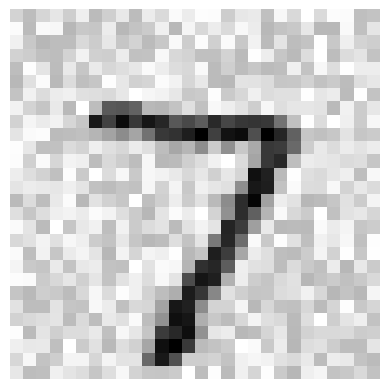

In [84]:
# Assuming X_test_mod is a DataFrame
image_data = X_test_mod.iloc[0].to_numpy().astype(int)  # Convert to NumPy array and int
image = image_data.reshape(28, 28)  # Reshape into 28x28 image
plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")